In [149]:
import os
import random
import matplotlib.pyplot as plt
import cv2 as cv
from tqdm import tqdm
import numpy as np

In [150]:

from google.colab import drive
drive.mount('/content/drive')


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [151]:
data_path = '/content/drive/MyDrive/Colab Notebooks/animal_dataset'

In [152]:
folder_path = '/content/animals_dataset'

In [153]:

categories = [c for c in os.listdir(data_path)]
print(categories)


['panda', 'dog', 'cat']


In [154]:

data = []
for c in categories:
    path = os.path.join(data_path, c)
    class_num = categories.index(c)

    for img in tqdm(os.listdir(path)):
        img_arr = cv.imread(os.path.join(path, img), cv.IMREAD_GRAYSCALE)
        img_arr = cv.resize(img_arr, (32,32), interpolation=cv.INTER_AREA)
        data.append([img_arr, class_num])

print(f"\nTotal data size: {len(data)}")

100%|██████████| 100/100 [00:00<00:00, 140.38it/s]


Total data size: 300


In [155]:
random.shuffle(data)
print(f"\nTotal images loaded: {len(data)}")


Total images loaded: 300


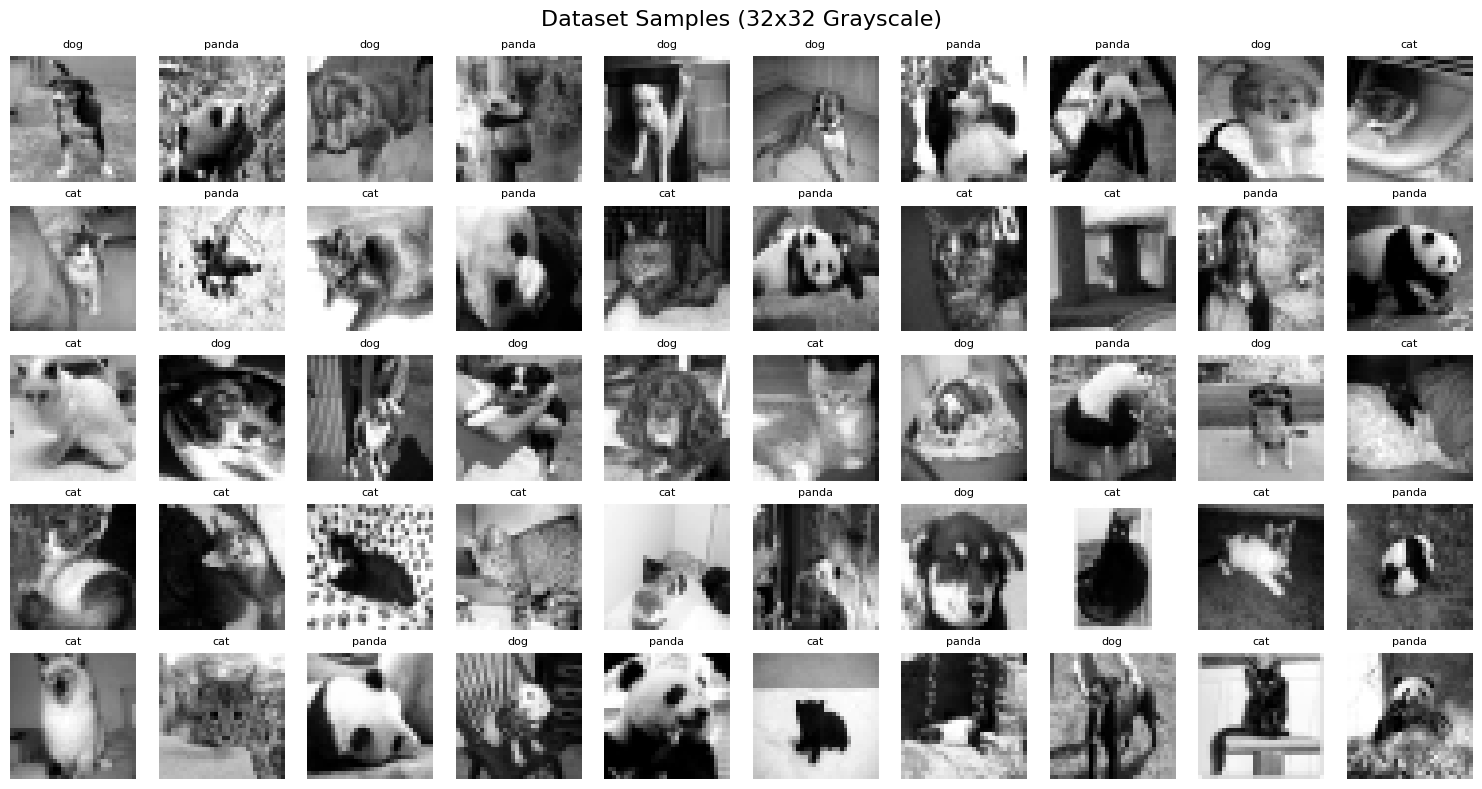

In [156]:
X = []
y = []
for features, label in data:
    X.append(features)
    y.append(label)

X = np.array(X)
y = np.array(y)


num_to_show = min(50, len(data))
plt.figure(figsize=(15, 8))
for i in range(num_to_show):
    plt.subplot(5, 10, i+1)
    plt.imshow(X[i], cmap='gray')
    plt.title(categories[y[i]], fontsize=8)
    plt.axis('off')
plt.suptitle("Dataset Samples (32x32 Grayscale)", fontsize=16)
plt.tight_layout()
plt.show()

In [157]:
# Manhattan Distance (L1)
def l1_dist(p1, p2):
    return np.sum(np.abs(p1 - p2))

# Euclidean Distance (L2)
def l2_dist(p1, p2):
    return np.sqrt(np.sum((p1 - p2)**2))


def get_neighbors_and_predict(train_X, train_y, test_point, k, metric_function):
    distances = []


    for i in range(len(train_X)):
        dist = metric_function(test_point, train_X[i])
        distances.append((dist, train_y[i]))


    distances.sort(key=lambda x: x[0])


    neighbors = distances[:k]


    output_labels = [row[1] for row in neighbors]
    prediction = max(set(output_labels), key=output_labels.count)

    return prediction

In [166]:
fold_results_l1 = np.array(fold_results_l1).T
fold_results_l2 = np.array(fold_results_l2).T
num_folds = 5
fold_size = len(X) // num_folds

folds_X = []
folds_y = []


for i in range(num_folds):
    start = i * fold_size
    end = (i + 1) * fold_size

    if i == num_folds - 1:
        end = len(X)
    folds_X.append(X[start:end])
    folds_y.append(y[start:end])


k_range = list(range(1, 20, 2))

l1_accuracies = []
l2_accuracies = []

print(f"Starting 5-Fold CV on {len(X)} images...")

for k in k_range:
    fold_l1_acc = []
    fold_l2_acc = []


    for i in range(num_folds):

        X_val = folds_X[i]
        y_val = folds_y[i]


        X_train = np.concatenate([folds_X[j] for j in range(num_folds) if j != i])
        y_train = np.concatenate([folds_y[j] for j in range(num_folds) if j != i])

        correct_l1 = 0
        correct_l2 = 0


        for idx, test_img in enumerate(X_val):
            # L1 Prediction
            pred_l1 = get_neighbors_and_predict(X_train, y_train, test_img, k, l1_dist)
            if pred_l1 == y_val[idx]:
                correct_l1 += 1

            # L2 Prediction
            pred_l2 = get_neighbors_and_predict(X_train, y_train, test_img, k, l2_dist)
            if pred_l2 == y_val[idx]:
                correct_l2 += 1


        fold_l1_acc.append(correct_l1 / len(X_val))
        fold_l2_acc.append(correct_l2 / len(X_val))


    avg_l1 = np.mean(fold_l1_acc)
    avg_l2 = np.mean(fold_l2_acc)
    l1_accuracies.append(avg_l1)
    l2_accuracies.append(avg_l2)

    print(f"K={k}\t L1 Acc: {avg_l1:.2f}\t L2 Acc: {avg_l2:.2f}")

print("Cross-Validation Complete.")

Starting 5-Fold CV on 300 images...
K=1	 L1 Acc: 0.40	 L2 Acc: 0.37
K=3	 L1 Acc: 0.41	 L2 Acc: 0.37
K=5	 L1 Acc: 0.41	 L2 Acc: 0.35
K=7	 L1 Acc: 0.39	 L2 Acc: 0.36
K=9	 L1 Acc: 0.43	 L2 Acc: 0.36
K=11	 L1 Acc: 0.42	 L2 Acc: 0.37
K=13	 L1 Acc: 0.42	 L2 Acc: 0.36
K=15	 L1 Acc: 0.42	 L2 Acc: 0.35
K=17	 L1 Acc: 0.40	 L2 Acc: 0.35
K=19	 L1 Acc: 0.39	 L2 Acc: 0.36
Cross-Validation Complete.



--- Top 5 Predictions Demo ---


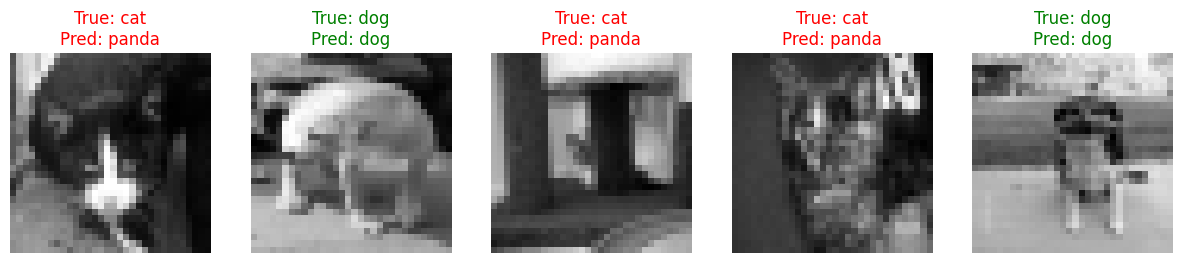

In [169]:
print("\n--- Top 5 Predictions Demo ---")
best_k = 5
indices = random.sample(range(len(X)), min(5, len(X)))

plt.figure(figsize=(15, 4))
for i, idx in enumerate(indices):
    test_img = X[idx]
    true_label = categories[y[idx]]


    X_temp_train = np.delete(X, idx, axis=0)
    y_temp_train = np.delete(y, idx, axis=0)

    pred_idx = get_neighbors_and_predict(X_temp_train, y_temp_train, test_img, best_k, l1_dist)
    pred_label = categories[pred_idx]


    col = 'green' if pred_label == true_label else 'red'

    plt.subplot(1, 5, i+1)
    plt.imshow(test_img, cmap='gray')
    plt.title(f"True: {true_label}\nPred: {pred_label}", color=col)
    plt.axis('off')
plt.show()